In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from IPython.display import display
pd.set_option('max_rows', 5)
%matplotlib inline

# 正則化 (regularization)
---
モデルの複雑さに制限を加えて過学習を抑制する手法のこと。

<table class="border text-center">
    <tr class="background-bright">
        <th>データとモデルの複雑さの関係</th>
        <th>現象</th>
        <th>対処法</th>
        <th>具体例</th>
    </tr>
    <tr class="background-dark">
        <td rowspan="2">データの複雑さ < モデルの複雑さ</td>
        <td rowspan="2">過学習</td>
        <td>データの複雑さを上げる<br />(データに含まれる情報を増やす)</td>
        <td class="text-left">
            <ul>
                <li>学習データを増やす</li>
            </ul>
        </td>
    </tr>
    <tr class="background-dark">
        <td>モデルの複雑さを下げる</td>
        <td class="text-left">
            <ul>
                <li><span style="color: red;">正則化</span></li>
                <li>パラメータを減らす</li>
                <li>高バイアスなモデルに変更する</li>
            </ul>
        </td>
    </tr>
    <tr class="background-dark">
        <td rowspan="2">データの複雑さ > モデルの複雑さ</td>
        <td rowspan="2">未学習</td>
        <td>データの複雑さを下げる<br />(モデルが理解しやすい形のデータにする)</td>
        <td class="text-left">
            <ul>
                <li>前処理 (特徴変形)</li>
            </ul>
        </td>
    </tr>
    <tr class="background-dark">
        <td>モデルの複雑さを上げる</td>
        <td class="text-left">
            <ul>
                <li>パラメータを増やす</li>
                <li>高バリアンスなモデルに変更する</li>
            </ul>
        </td>
    </tr>
</table>

**正則化は特徴のスケールに影響される**ものが多いので、実行する際は特徴の標準化 (変数が平均0・分散1になるような変換) $
{\displaystyle X'=\frac
    {X-\mu }
    {\sigma }
}
$ が必要。

以下では、回帰方程式を $y=w_{1} x_{1} +w_{2} x_{2} +\cdots +w_{k} x_{k} +b$ として表している。

## L2正則化
---
最も代表的な正則化手法。パラメータの値を小さく保つことでモデルに制限を加え、過学習を抑制。  
損失関数に以下の正則化項を加える。

$
{\displaystyle \frac
    {\alpha }
    {2} 
\| w\| ^{2} =\frac
    {\alpha }
    {2}
\sum ^{k}_{i=1} w^{2}_{i}}
$

重み (荷重) 減衰とも呼ばれ、線形回帰にL2正則化を適用したもの (最小化する対象を残差二乗和+L2正則化項にしたもの) をリッジ回帰 (Ridge Regression) という。  
リッジ回帰の損失関数は $
\displaystyle \frac
    {1}
    {2n}
\sum ^{n}_{i=1} e^{2}_{i} +\frac
    {\alpha }
    {2}
\sum ^{k}_{i=1} w^{2}_{i}
$ で表される。 $\displaystyle \frac{1}{2}$ は微分したときに消えるようについているだけなので、気にする必要はない。

In [2]:
from my_functions.regularization import l2
l2.show()

interactive(children=(FloatLogSlider(value=1e-07, continuous_update=False, description='正則化の強さ $\\alpha$', min…

L2正則化は多重共線性の問題に対応できる。

### 多重共線性 (multicollinearity)
---
説明変数間、あるいは複数の説明変数の組み合わせと他の説明変数の間に高い相関がある状態。

以下のような問題を引き起こす。

- (統計解析) 得られた回帰係数 (パラメータ) の値がサンプリングのたびに安定せず、パラメーターの正負が逆転することも
- (統計解析) 第二種の誤り (帰無仮説が誤っているのに採択) を起こしやすくなる
- (機械学習) 過学習しやすくなる

多重共線性は、元々のデータセットに存在することもあるが、自ら作り上げてしまう場合もある。以下のダミー変数化では最後の1列は他2列から完全に予測可能であり、多重共線性が生じている。

<table class="border text-center">
    <tr>
        <th class="border-top-none border-left-none background-default" rowspan="2"></th>
        <th class="border-bottom background-dark">カテゴリ変数</th>
        <td class="border-none background-default" rowspan="2"></td>
        <th class="border-bottom background-dark" colspan="3">ダミー変数</th>
    </tr>
    <tr class="background-dark">
        <th>色</th>
        <th>赤</th>
        <th>緑</th>
        <th>青</th>
    </tr>
    <tr class="background-bright">
        <td>1</td>
        <td>赤</td>
        <td class="border-none background-default" rowspan="3">→</td>
        <td class="text-blue">1</td>
        <td class="text-blue">0</td>
        <td class="text-red">0</td>
    </tr>
    <tr class="background-bright">
        <td>2</td>
        <td>緑</td>
        <td class="text-blue">0</td>
        <td class="text-blue">1</td>
        <td class="text-red">0</td>
    </tr>
    <tr class="background-bright">
        <td>3</td>
        <td>青</td>
        <td class="text-blue">0</td>
        <td class="text-blue">0</td>
        <td class="text-red">1</td>
    </tr>
</table>

多重共線性の問題は、説明変数 (特徴) が2つの線形回帰を例に以下のように考えるとわかりやすい。

1. 線形回帰では説明変数同士は無相関だと仮定している (説明変数の分布が一様分布なら、データは平面上に偏りなく存在)
1. 説明変数同士に高い相関があるとデータは平面ではなく直線上に分布している
1. 被説明変数を加えた特徴空間では線形回帰は平面 (予測平面) を求めようとするが、説明変数が直線上に分布しているため平面が1つに定まらない (訓練データに含まれるノイズ (誤差) によって係数が安定しない)

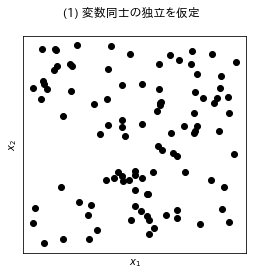

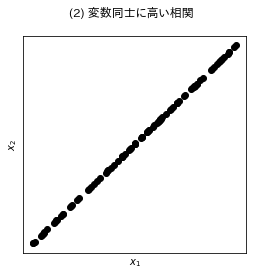

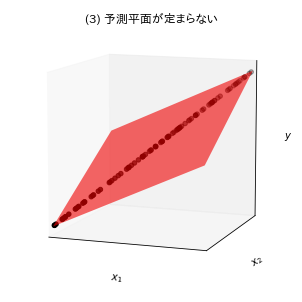

In [3]:
from my_functions.regularization import multicollinearity
multicollinearity.show()

ただし、**予測を目的とする場合**は、ダミー変数化のように係数が変わっても予測値に影響しないときは問題ない。 (予測値に変化が生じる場合は過学習の危険があるので対処が必要)

### 係数の変化
---
下のグラフでは、正則化を強める ( $\alpha$ の値を大きくする) につれて係数の (相対的な) 大きさが安定していくのがわかる。

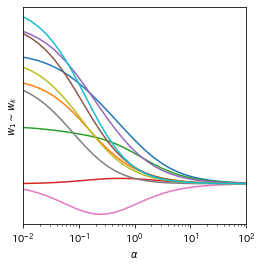

In [4]:
from my_functions.regularization import l2_weights
l2_weights.show()

### 損失関数の変化
---
L2 正則化項の勾配を下ると原点に近づく = $w$ の最適解をパラメーター空間内の原点に近づける効果を持つ

In [5]:
# 3Dグラフの表示に必要
%matplotlib widget
%matplotlib widget

In [6]:
from my_functions.regularization import l2_cost
l2_cost.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(ToggleButtons(description='損失関数', options=(('MSE', 1), ('L2', 2), ('MSE+L2', 3)), value=…

### Pythonでのリッジ回帰の実行方法
---
`sklearn.linear_model.Ridge`を使用する。

In [7]:
loader = load_boston()
boston = pd.DataFrame(np.column_stack([loader.data, loader.target]),
                      columns=list(loader.feature_names) + ['target'])
print('boston')
display(boston)

boston


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,396.90,7.88,11.9


In [8]:
help(Ridge)

Help on class Ridge in module sklearn.linear_model._ridge:

class Ridge(sklearn.base.MultiOutputMixin, sklearn.base.RegressorMixin, _BaseRidge)
 |  Ridge(alpha=1.0, *, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, solver='auto', random_state=None)
 |  
 |  Linear least squares with l2 regularization.
 |  
 |  Minimizes the objective function::
 |  
 |  ||y - Xw||^2_2 + alpha * ||w||^2_2
 |  
 |  This model solves a regression model where the loss function is
 |  the linear least squares function and regularization is given by
 |  the l2-norm. Also known as Ridge Regression or Tikhonov regularization.
 |  This estimator has built-in support for multi-variate regression
 |  (i.e., when y is a 2d-array of shape (n_samples, n_targets)).
 |  
 |  Read more in the :ref:`User Guide <ridge_regression>`.
 |  
 |  Parameters
 |  ----------
 |  alpha : {float, ndarray of shape (n_targets,)}, default=1.0
 |      Regularization strength; must be a positive float. Regul

In [9]:
ridge = Ridge(alpha=0.3)
x = boston.iloc[:, :-1]
y = boston.iloc[:, -1]
ridge.fit(x, y)
ridge.score(x, y)

0.7403394824615863

## L1正則化
---
影響の少ないパラメータの値を0にすることでモデルに制限を加え、過学習を抑制。重要な特徴を選択。  
損失関数に以下の正則化項を加える。

${\displaystyle \alpha \| w\| =\alpha \sum ^{k}_{i=1}| w_{i}| }$

線形回帰にL1正則化を適用したもの (最小化する対象を残差二乗和+L1正則化項にしたもの) をラッソ回帰 (Lasso Regression) という。

ラッソ回帰の損失関数は $
\displaystyle \frac
    {1}
    {2n}
\sum ^{n}_{i=1} e^{2}_{i} +\alpha \sum ^{k}_{i=1}| w_{i}| 
$ で表される。

In [10]:
# 通常表示に戻す
%matplotlib inline

In [11]:
from my_functions.regularization import l1
l1.show()

interactive(children=(FloatLogSlider(value=1e-05, continuous_update=False, description='正則化の強さ $\\alpha$', max…

### 係数の変化
---
下のグラフでは、正則化を強める ( $\alpha$ の値を大きくする) につれて係数の大きさが直線的に減少していくのがわかる。

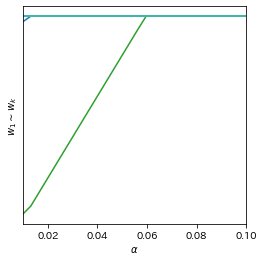

In [12]:
from my_functions.regularization import l1_weights
l1_weights.show()

### 損失関数の変化
---
L1 正則化項の勾配を下る (等高線に対して垂直に進む) と軸に近づく = $w$ の最適解をパラメーター空間内の軸に近づける効果を持つ

In [13]:
# 3Dグラフの表示に必要
%matplotlib widget
%matplotlib widget

In [14]:
from my_functions.regularization import l1_cost
l1_cost.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(ToggleButtons(description='損失関数', options=(('MSE', 1), ('L1', 2), ('MSE+L1', 3)), value=…

### Pythonでのラッソ回帰の実行方法
---
`sklearn.linear_model.Lasso`を使用する。

In [15]:
lasso = Lasso(alpha=0.3)
lasso.fit(x, y)
lasso.score(x, y)

0.7206350048380019

## Elastic-Net
---
L1 ・ L2 両方の正則化を適用した線形回帰。

### PythonでのElastic-Netの実行方法
---
`sklearn.linear_model.ElasticNet`を使用する。

In [16]:
en = ElasticNet(alpha=0.3, l1_ratio=0.2)
en.fit(x, y)
en.score(x, y)

0.7129920748412979

## 推薦図書
---
- [Python 機械学習プログラミング 達人データサイエンティストによる理論と実践](https://www.amazon.co.jp/Python-%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%83%97%E3%83%AD%E3%82%B0%E3%83%A9%E3%83%9F%E3%83%B3%E3%82%B0-%E9%81%94%E4%BA%BA%E3%83%87%E3%83%BC%E3%82%BF%E3%82%B5%E3%82%A4%E3%82%A8%E3%83%B3%E3%83%86%E3%82%A3%E3%82%B9%E3%83%88%E3%81%AB%E3%82%88%E3%82%8B%E7%90%86%E8%AB%96%E3%81%A8%E5%AE%9F%E8%B7%B5-impress-gear/dp/4295003379/)
- [見て試してわかる機械学習アルゴリズムの仕組み 機械学習図鑑](https://www.amazon.co.jp/%E8%A6%8B%E3%81%A6%E8%A9%A6%E3%81%97%E3%81%A6%E3%82%8F%E3%81%8B%E3%82%8B%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%82%A2%E3%83%AB%E3%82%B4%E3%83%AA%E3%82%BA%E3%83%A0%E3%81%AE%E4%BB%95%E7%B5%84%E3%81%BF-%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E5%9B%B3%E9%91%91-%E7%A7%8B%E5%BA%AD-%E4%BC%B8%E4%B9%9F/dp/4798155659/)